<a href="https://www.kaggle.com/code/lekhatopil/backpack-price-prediction-eda-lightgbm?scriptVersionId=293170644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **About**

This notebook is focused on **analyzing and predicting backpack prices** using the competition dataset. The key steps and methodologies employed in this project include:

**Data Exploration:** I began by exploring the data distribution to gain insights into the underlying patterns and characteristics of the dataset.

**Handling Missing Values:** Mild missing values were present in several columns. For continuous variables, I imputed the missing values with the **mean**. For categorical variables, I used **random imputation** instead of **mode** to preserve the data distribution.

**Feature Engineering:** Given the dataset's emphasis on categorical variables, I created **meaningful interactions among these features** to enhance the predictive power of our model.

**Model Building:** Our primary goal is to build a robust prediction model to accurately estimate backpack prices. I utilized the **LightGBM model**, known for its efficiency and performance in handling large datasets.

**Validation:** To ensure the reliability of our model, I implemented **KFold cross-validation** with **5 folds**. This technique helps in assessing the model's performance on different subsets of the training data.

**Evaluation Metric:** The model's performance is evaluated using the **Root Mean Squared Error (RMSE) metric**, which measures the differences between predicted and actual backpack prices.

Additionally, I initially created some aggregated features by grouping the **`weight_capacity_(kg)`** column with **`price`**, including statistics such as **mean, median, standard deviation, skew, and count**. While these features **improved my cross-validation scores**, they slightly reduced the test scores. Consequently, I decided to remove these features. As the **`weight_capacity_(kg)`** feature ranked highest in feature importance, I initially thought that creating these new features would generalize well.

In [1]:
# Import packages              
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno

import optuna
from xgboost import XGBRegressor  
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.metrics import mean_squared_error, make_scorer


import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)  
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
# Read Train and Test data   
train_df = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')

train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [3]:
test_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [4]:
# Check Train and Test data size  
print('Train:', train_df.shape)
print('Test:', test_df.shape)      

Train: (300000, 11)
Test: (200000, 10)


In [5]:
# Display train_df  
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [6]:
# Display test_df
test_df.head()  

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


# **Data Cleaning**

In [7]:
# Change column names to lower_case & replace space with underscore
train_df.columns = train_df.columns.str.replace(' ', '_').str.lower()
test_df.columns = test_df.columns.str.replace(' ', '_').str.lower()

print('Train:\n', train_df.columns)
print('Test:\n',  test_df.columns) 

Train:
 Index(['id', 'brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'waterproof', 'style', 'color', 'weight_capacity_(kg)', 'price'],
      dtype='object')
Test:
 Index(['id', 'brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'waterproof', 'style', 'color', 'weight_capacity_(kg)'],
      dtype='object')


In [8]:
# Check for Duplicates
print('Count of Duplicated rows in train_df:', train_df.duplicated().sum())
print('Count of Duplicated rows in test_df:', test_df.duplicated().sum())

Count of Duplicated rows in train_df: 0
Count of Duplicated rows in test_df: 0


In [9]:
# Check whether both datasets train_df and test_df have same categorical columns
train_df.select_dtypes(include=['object']).columns.tolist() == test_df.select_dtypes(include=['object']).columns.tolist()

True

In [10]:
# Check whether both datasets have same unique categories for categorical variables
# Extract all catgorical variables
categorical = train_df.select_dtypes(include=['object']).columns.tolist()

# Creat dictionary to hold unqiue categories for each categorical variable for train and test datasets
categorical_train = {var: set(train_df[var].dropna().unique()) for var in categorical}
categorical_test = {var: set(test_df[var].dropna().unique()) for var in categorical}

categorical_train == categorical_test 

True

In [11]:
# Check categorical variables with unique categories in train_df
print('Train Dataset:')
categorical_train

Train Dataset:


{'brand': {'Adidas', 'Jansport', 'Nike', 'Puma', 'Under Armour'},
 'material': {'Canvas', 'Leather', 'Nylon', 'Polyester'},
 'size': {'Large', 'Medium', 'Small'},
 'laptop_compartment': {'No', 'Yes'},
 'waterproof': {'No', 'Yes'},
 'style': {'Backpack', 'Messenger', 'Tote'},
 'color': {'Black', 'Blue', 'Gray', 'Green', 'Pink', 'Red'}}

In [12]:
# Check categorical variables with unique categories in test_df
print('Test Dataset:')
categorical_test

Test Dataset:


{'brand': {'Adidas', 'Jansport', 'Nike', 'Puma', 'Under Armour'},
 'material': {'Canvas', 'Leather', 'Nylon', 'Polyester'},
 'size': {'Large', 'Medium', 'Small'},
 'laptop_compartment': {'No', 'Yes'},
 'waterproof': {'No', 'Yes'},
 'style': {'Backpack', 'Messenger', 'Tote'},
 'color': {'Black', 'Blue', 'Gray', 'Green', 'Pink', 'Red'}}

In [13]:
print('Train Dataset:')
train_df.info()
print()
print('Test Dataset')
test_df.info()

Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   brand                 290295 non-null  object 
 2   material              291653 non-null  object 
 3   size                  293405 non-null  object 
 4   compartments          300000 non-null  float64
 5   laptop_compartment    292556 non-null  object 
 6   waterproof            292950 non-null  object 
 7   style                 292030 non-null  object 
 8   color                 290050 non-null  object 
 9   weight_capacity_(kg)  299862 non-null  float64
 10  price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB

Test Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Colum

# **Distribution Analysis of Categorical Variables**

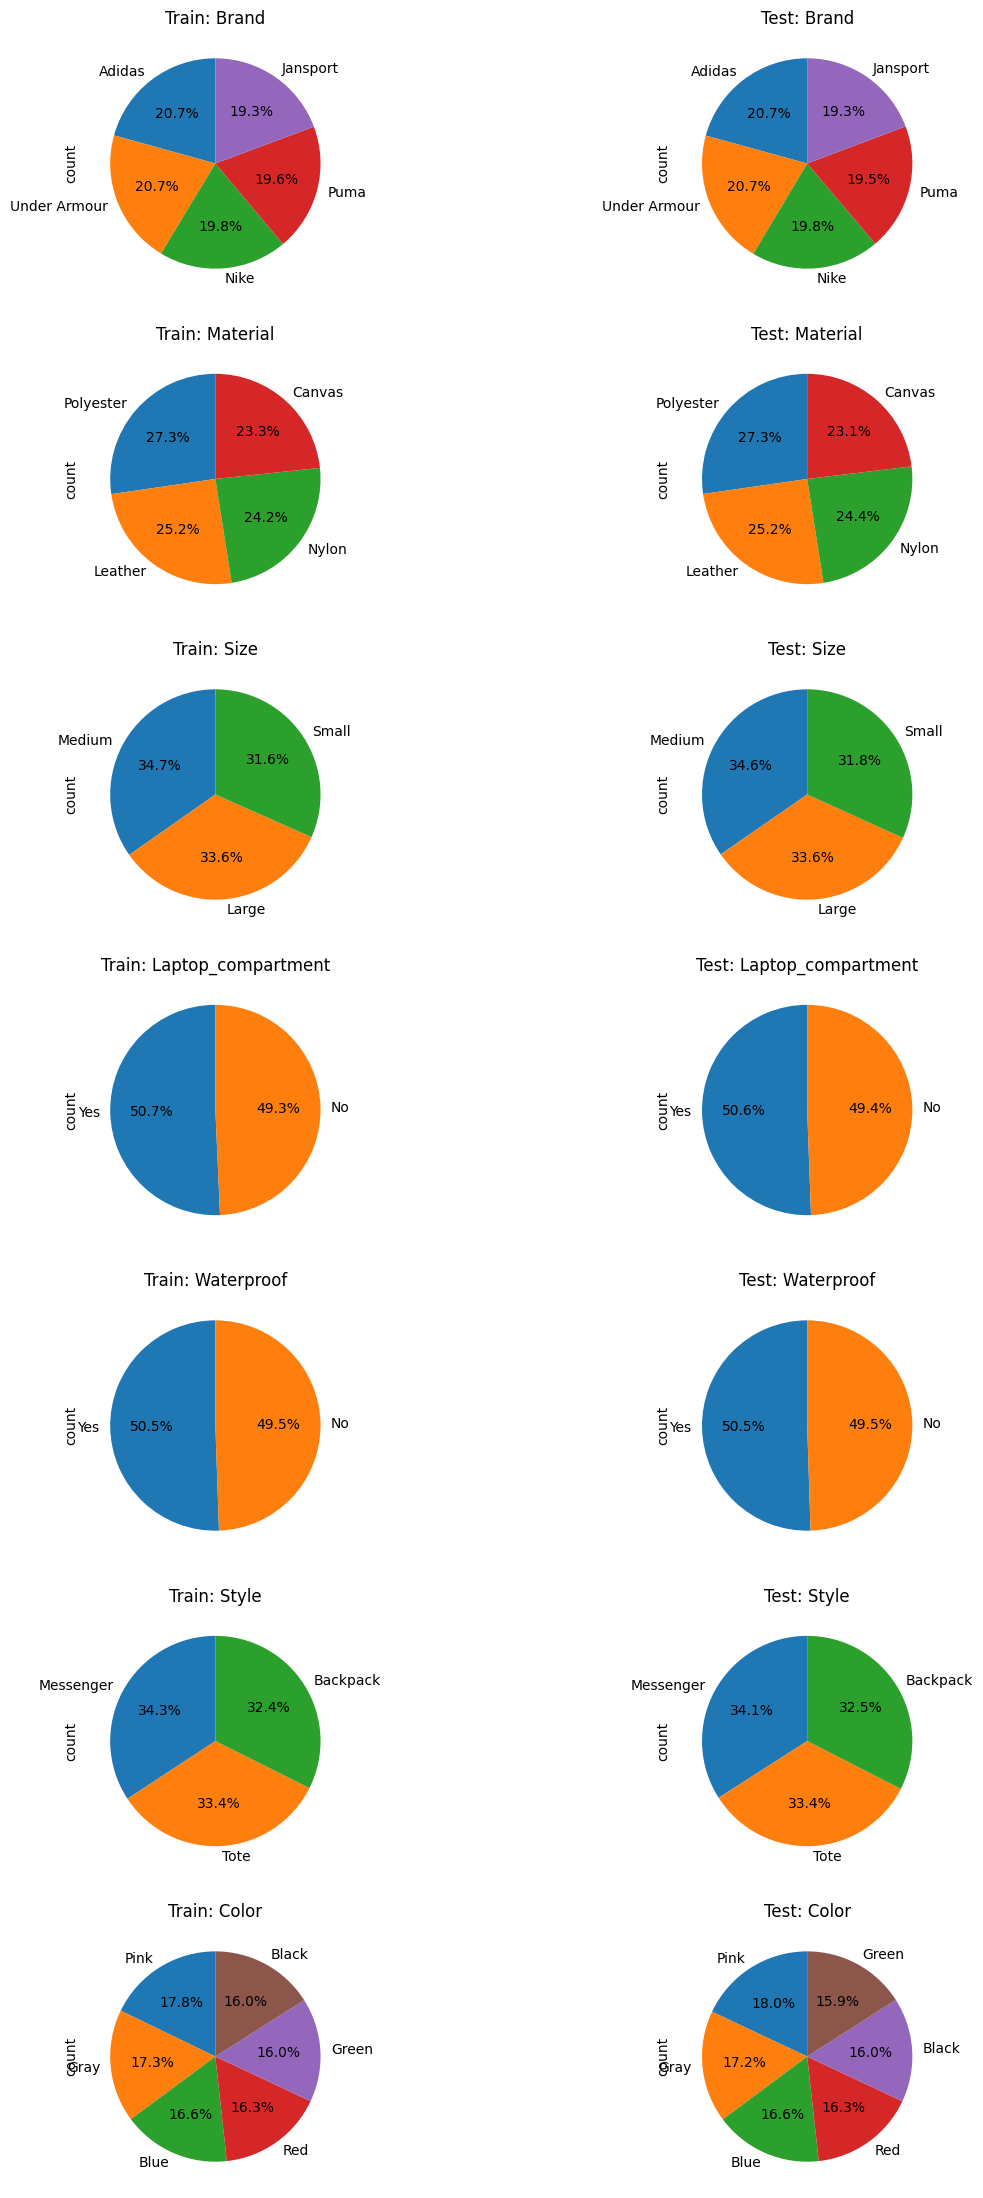

In [14]:
# Create subplots
fig, axes = plt.subplots(len(categorical), 2, figsize=(14, 4 * len(categorical)))

# Loop through each categorical variable
for i, var in enumerate(categorical):
    # Train DataFrame Pie Chart 
    train_df[var].value_counts().plot.pie(ax=axes[i, 0], autopct='%1.1f%%', 
                                         startangle=90, title=f'Train: {var.capitalize()}')
    # Test DataFrame Pie Chart
    test_df[var].value_counts().plot.pie(ax=axes[i, 1], autopct='%1.1f%%', 
                                         startangle=90, title=f'Test: {var.capitalize()}')   

There are **seven categorical variables** in both **`train_df`** and **`test_df`**. Each of these categorical variables demonstrates a **balanced distribution** across their unique categories. While the percentage distribution of these categories is similar between the two datasets, it is not identical.   

In [15]:
# Extract all numerical variables               
numerical = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove('id')
numerical.remove('price')
numerical        

['compartments', 'weight_capacity_(kg)']

In [16]:
# Check for infinite values in the `price` column
train_df['price'].isin([np.inf, -np.inf]).any()      

False

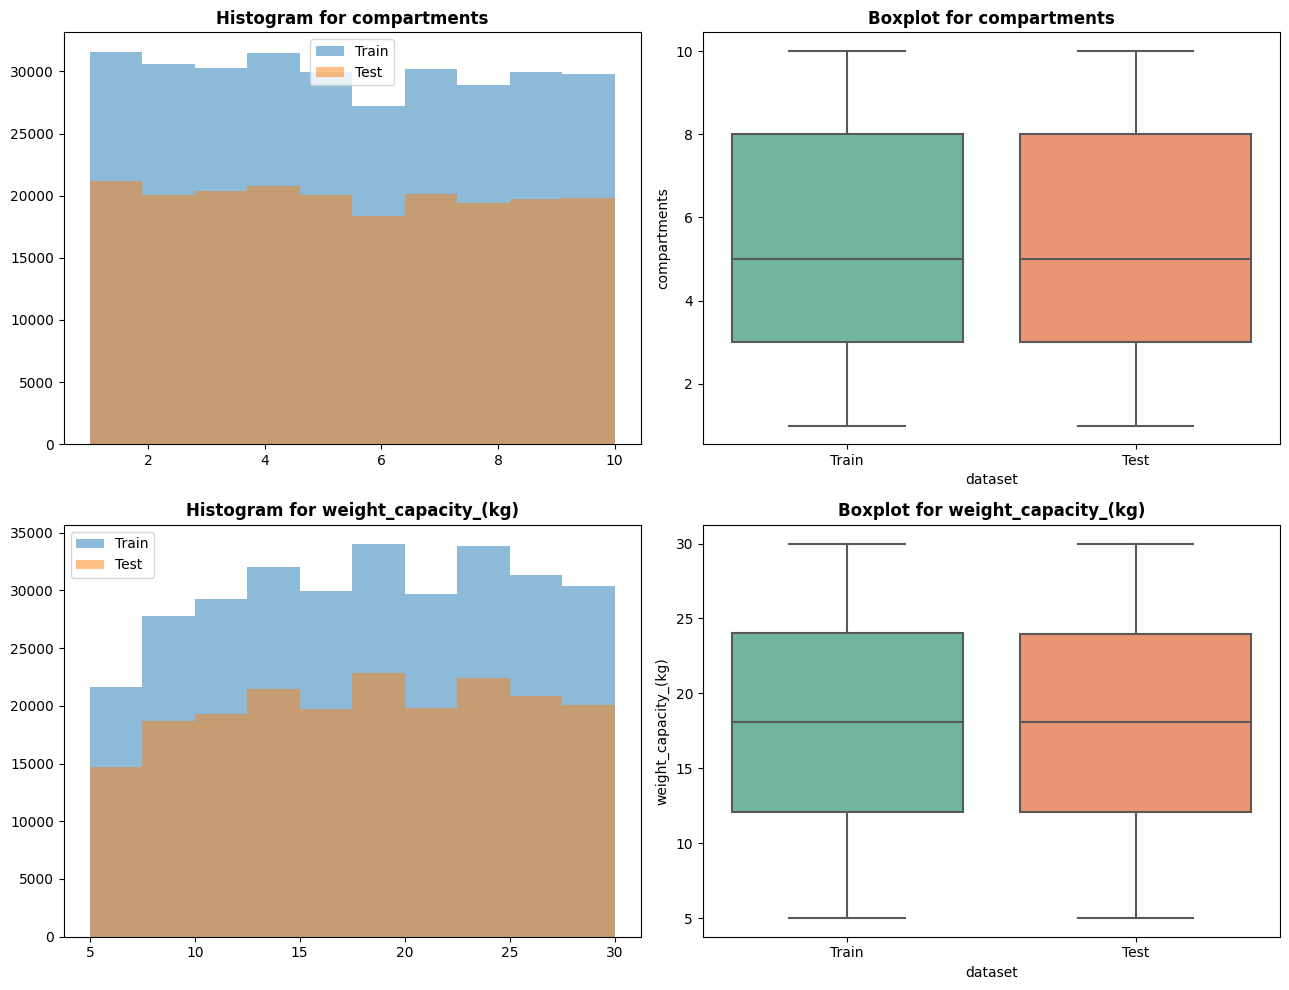

In [17]:
# Setup subplots
fig, axes = plt.subplots(len(numerical), 2, figsize=(13, 5 * len(numerical)))

# Plot Histogram for Train & Test data
for i, var in enumerate(numerical):
    axes[i, 0].hist(train_df[var], alpha=0.5, label='Train')
    axes[i, 0].hist(test_df[var], alpha=0.5, label='Test')
    axes[i, 0].set_title(f'Histogram for {var}', weight='bold')
    axes[i, 0].legend()

    # Prepare data for boxplot
    combined = pd.concat([train_df[var].to_frame().assign(dataset='Train'),
                          test_df[var].to_frame().assign(dataset='Test')
                         ])
    # Plot Boxplot
    sns.boxplot(data=combined, x='dataset', y=var, ax=axes[i, 1], palette='Set2')
    axes[i, 1].set_title(f'Boxplot for {var}', weight='bold')

plt.tight_layout()
plt.show()

In [18]:
print('Train:')
print(train_df[['compartments', 'weight_capacity_(kg)']].describe())
print()
print('Test:')
print(train_df[['compartments', 'weight_capacity_(kg)']].describe())

Train:
        compartments  weight_capacity_(kg)
count  300000.000000         299862.000000
mean        5.443590             18.029994
std         2.890766              6.966914
min         1.000000              5.000000
25%         3.000000             12.097867
50%         5.000000             18.068614
75%         8.000000             24.002375
max        10.000000             30.000000

Test:
        compartments  weight_capacity_(kg)
count  300000.000000         299862.000000
mean        5.443590             18.029994
std         2.890766              6.966914
min         1.000000              5.000000
25%         3.000000             12.097867
50%         5.000000             18.068614
75%         8.000000             24.002375
max        10.000000             30.000000


The histograms show **similar distribution shapes**, indicating a comparable spread of data. The boxplots reveal **no outliers** and **similar interquartile ranges (IQRs)**, further supporting the consistency in data spread. Additionally, the **nearly identical statistical summaries** reinforce the observation that both the train and test datasets share a similar distribution.

# **Analyzing the Target Variable - Price** 

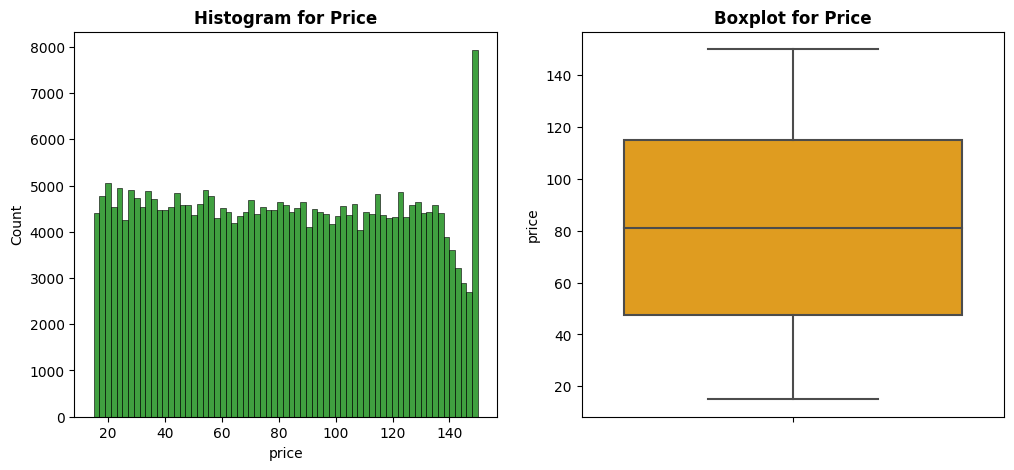

In [19]:
# Setup subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Histogram for `price`
sns.histplot(x=train_df['price'], ax=axes[0], color='green')
axes[0].set_title('Histogram for Price', weight='bold')

# Plot Boxplot for `price`
sns.boxplot(y=train_df['price'], ax=axes[1], color='orange')
axes[1].set_title('Boxplot for Price', weight='bold');  

In [20]:
# Descriptive statistic for `price`
train_df['price'].describe()         

count    300000.000000
mean         81.411107
std          39.039340
min          15.000000
25%          47.384620
50%          80.956120
75%         115.018160
max         150.000000
Name: price, dtype: float64

In [21]:
# Count `price` with and above 148
train_df[train_df['price']>=148].shape[0]  

7923

• The histogram for price **does not exhibit skewness**, indicating a fairly symmetrical distribution around the **mean (81.41) and median (80.95)**, which are closely aligned. However, a **significant peak in the last bin** suggests a concentration of prices near the upper bound (**148 and above**), with **7,923 observations**, while most other bins range from **4,000 to 5,000.**

• The boxplot shows a **centrally positioned interquartile range (IQR)** with the median at **80.95**, meaning the middle **50%** of prices are well-clustered around the median. **No outliers are detected** in the boxplot, suggesting that prices are consistently within the expected range.


# **Analyzing Price Trends by Categorical Factors**

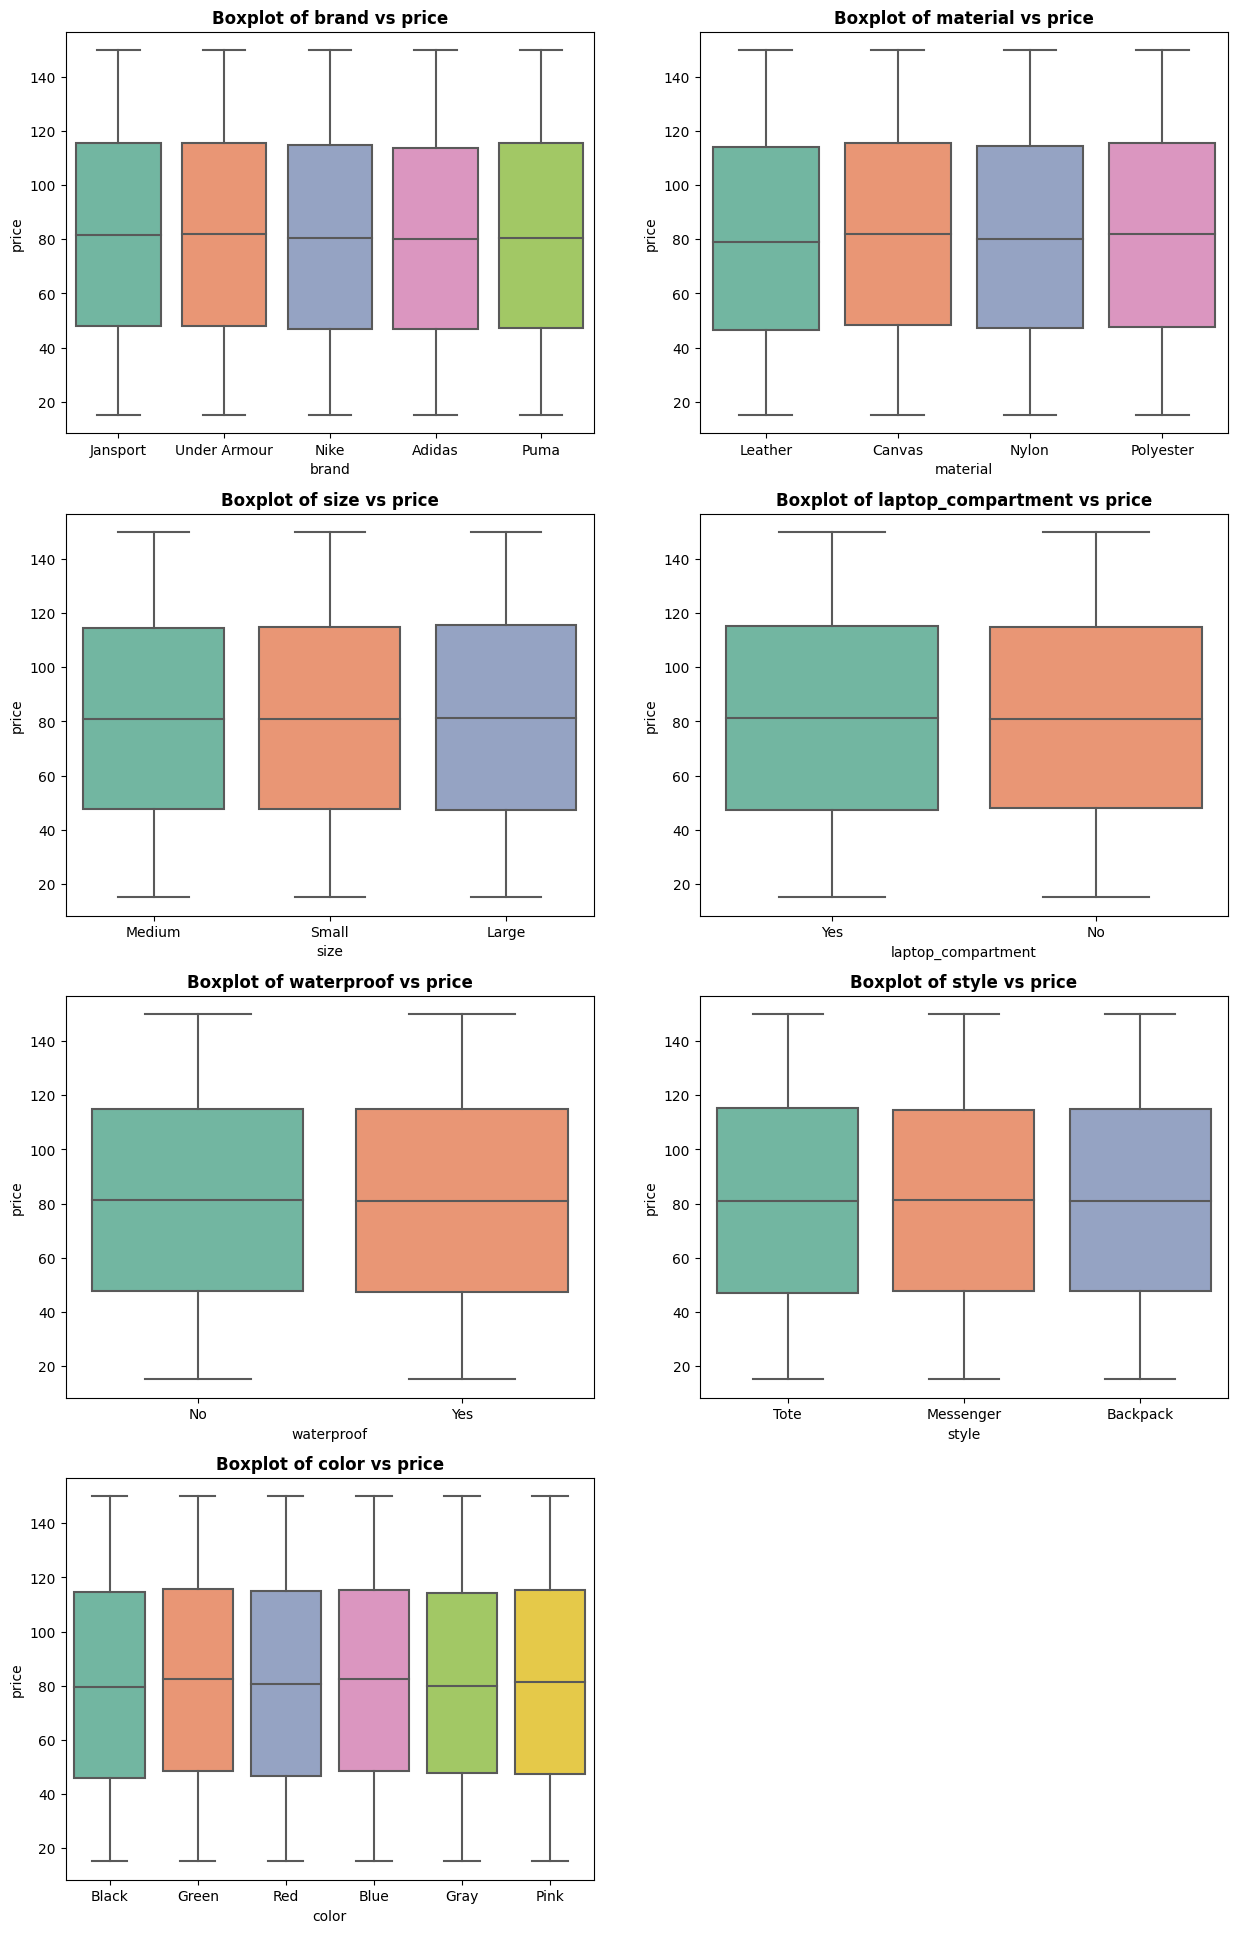

In [22]:
# Create subplots for Boxplot  
fig, axs = plt.subplots(len(categorical) // 2 + 1, 2, figsize=(15, 24))

# Flatten the axes array to iterate over each subplot
axs = axs.flatten()

# Plot histogram for each variables based on price
for i, var in enumerate(categorical):
    ax = axs[i]
    sns.boxplot(data=train_df, x=var, y='price', palette='Set2', ax=ax)
    ax.set_title(f'Boxplot of {var} vs price', size=12, weight='bold')

# Hide extra subplots
for j in range(len(categorical), len(axs)):
    axs[j].axis('off')

In [23]:
train_df.groupby('color')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
Black,46378.0,80.513439,39.212778,15.0,45.985187,79.51800,114.451325,150.0
Blue,48097.0,82.006994,38.833774,15.0,48.509020,82.30756,115.408850,150.0
Gray,50280.0,80.851971,38.682311,15.0,47.634620,79.78348,114.370117,150.0
Green,46386.0,82.381308,38.934312,15.0,48.568640,82.49228,115.694120,150.0
Pink,51690.0,81.630864,39.113769,15.0,47.305928,81.15240,115.308278,150.0
Red,47219.0,81.011644,39.391864,15.0,46.413770,80.72338,114.840210,150.0


The boxplot analysis reveals that all categorical variables **exhibit the same price distribution** across their unique categories, with **identical boxplot shapes.** However, the **`color`** variable shows **slight variations** in key statistics such as **mean, median, and quartiles**, though the differences remain minimal. This suggests that individual categorical features alone do not strongly influence the target variable **`price`.** To better capture meaningful patterns, we will explore **interactions between categorical features.**

# **Missing Values**

In [24]:
# Missing values in train_df data 
train_count = train_df.isna().sum()
train_perct = round(train_df.isna().sum() / len(train_df) * 100, 2) 

# Missing values in test_df data 
test_count = test_df.isna().sum()
test_perct = round(test_df.isna().sum() / len(test_df) * 100, 2) 

# Create a DataFrame for missing value summary for both datasets
missing_summary = pd.DataFrame({
       'train_count': train_count,
       'train_perct': train_perct,
       'test_count' : test_count,
       'test_perct' : test_perct
})

missing_summary  

,train_count,train_perct,test_count,test_perct
brand,9705,3.24,6227.0,3.11
color,9950,3.32,6785.0,3.39
compartments,0,0.00,0.0,0.00
id,0,0.00,0.0,0.00
laptop_compartment,7444,2.48,4962.0,2.48
material,8347,2.78,5613.0,2.81
price,0,0.00,NaN,NaN
size,6595,2.20,4381.0,2.19
style,7970,2.66,5153.0,2.58
waterproof,7050,2.35,4811.0,2.41


Our dataset has **mild missingness**. Out of **10** explanatory features, **8** have missing values, with each feature having nearly identical missing percentages in both the train and test datasets, consistently ranging from **0.05% to 3.39%.**  

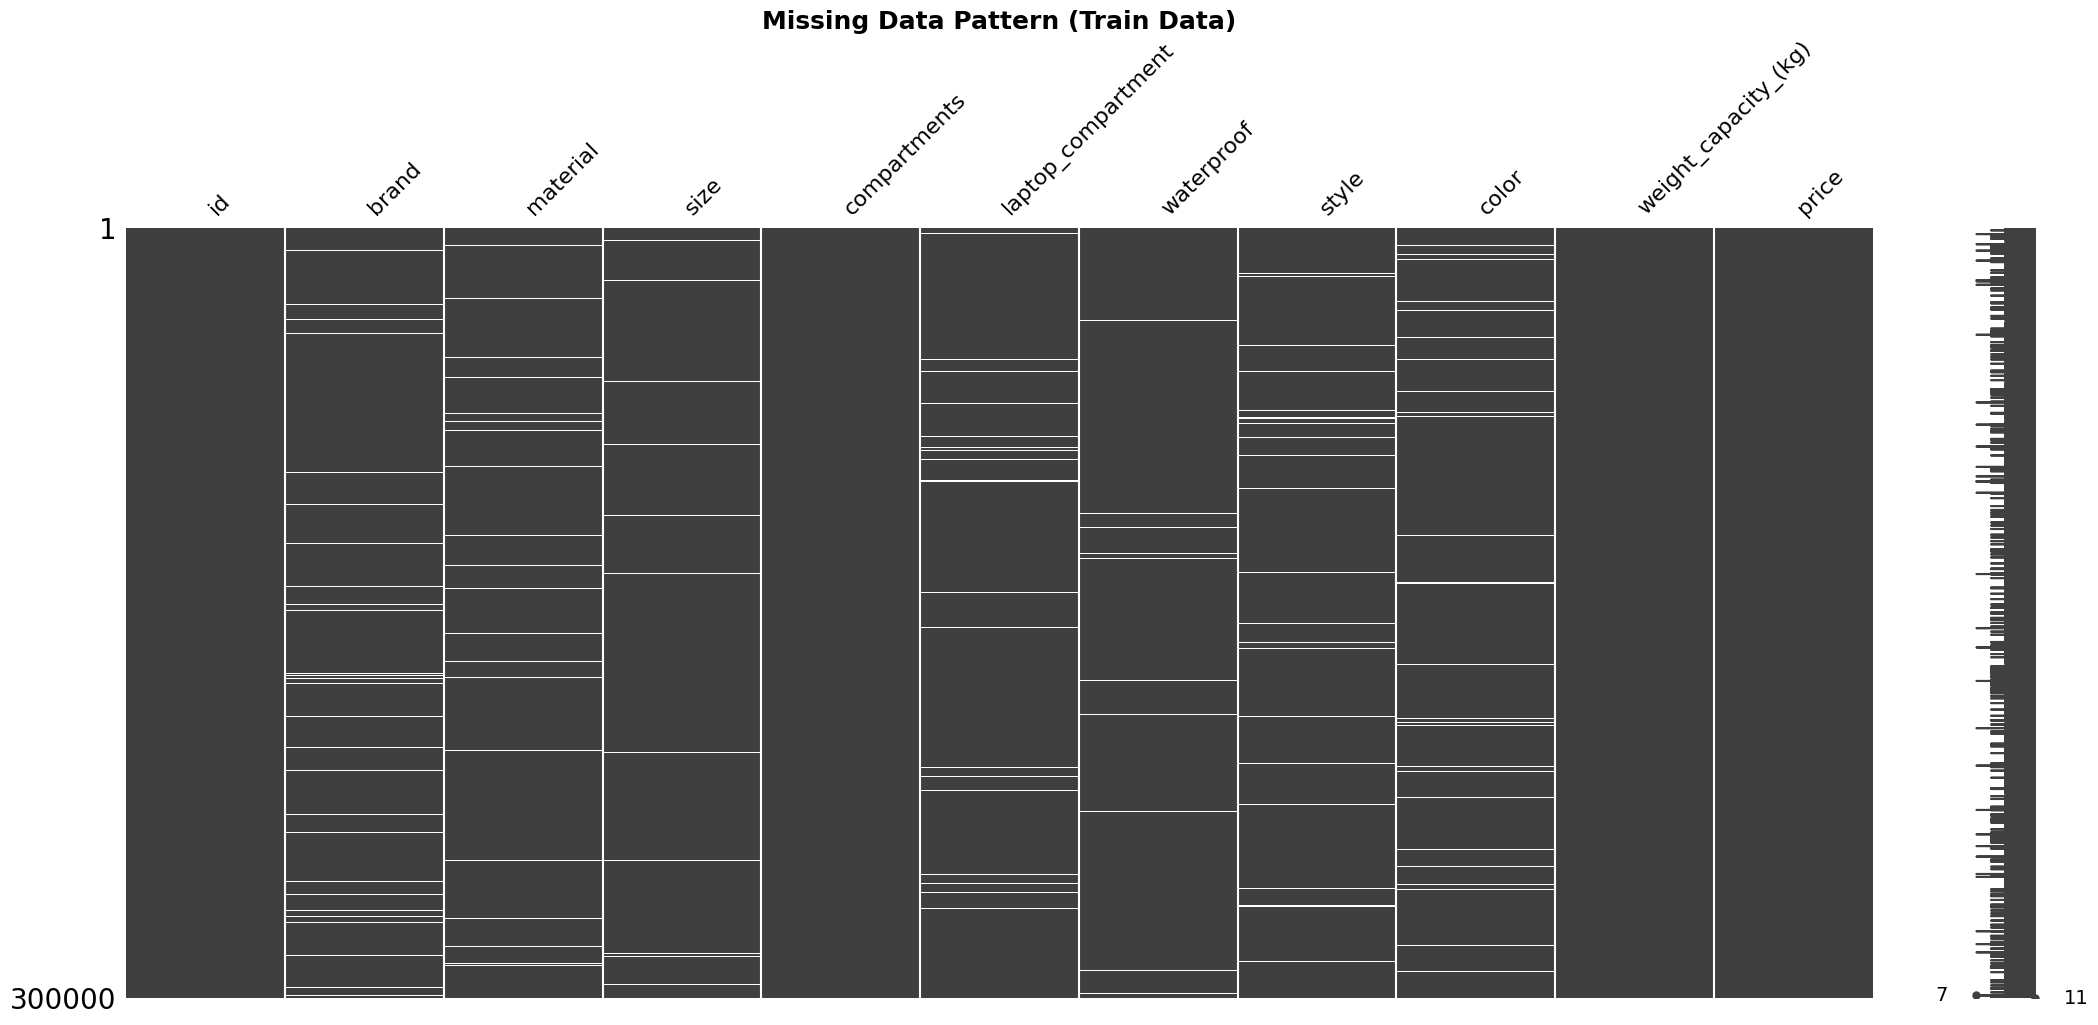

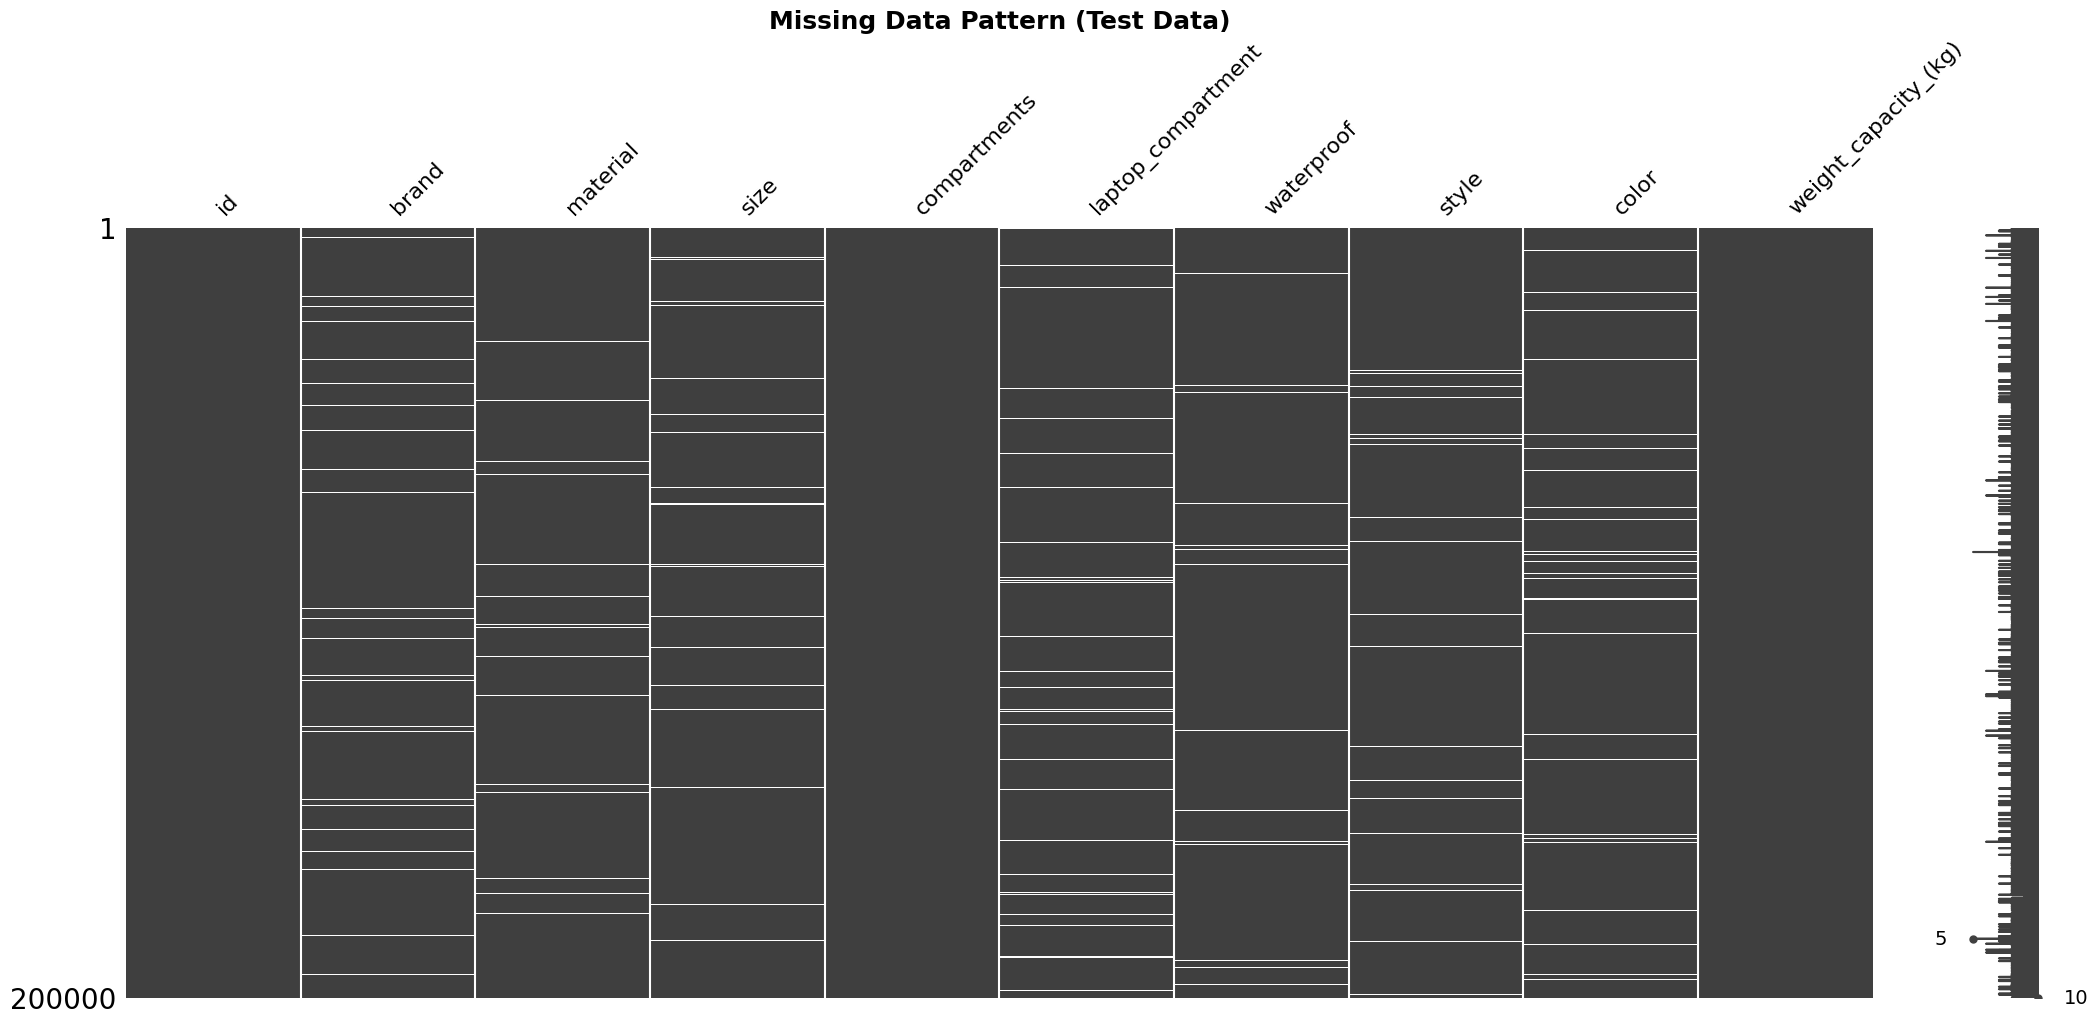

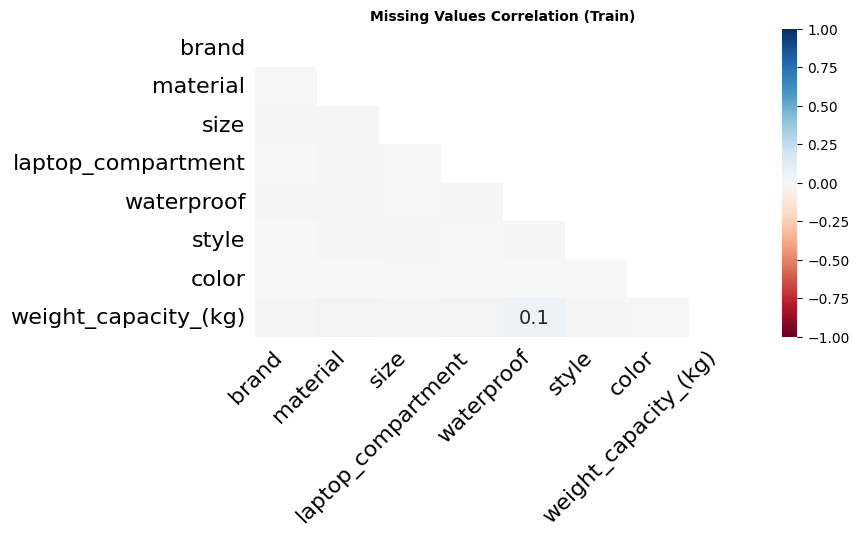

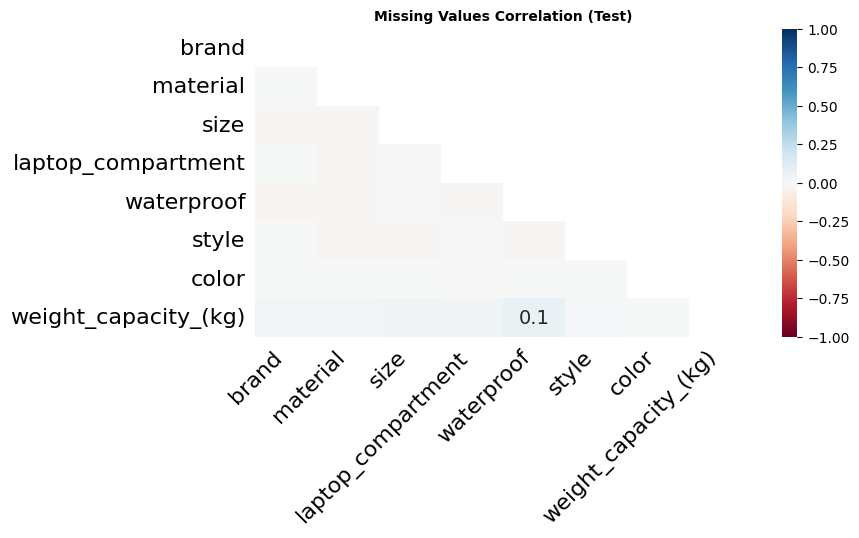

In [25]:
# Visualize missing data patterns
msno.matrix(train_df)
plt.title('Missing Data Pattern (Train Data)', size=18, weight='bold')
plt.show()

msno.matrix(test_df)
plt.title('Missing Data Pattern (Test Data)', size=18, weight='bold')
plt.show()

# Visualize missing data correlations
msno.heatmap(train_df, figsize=(8, 4))
plt.title('Missing Values Correlation (Train)', size=10, weight='bold')
plt.show()

msno.heatmap(test_df, figsize=(8, 4))
plt.title('Missing Values Correlation (Test)', size=10, weight='bold')
plt.show() 

The **msno.heatmap** visualization shows white cells for all features, except for the pair **`weight_capacity_(kg)`** and **`waterproof`**, which has a **0.1 correlation**. This indicates a **slight relationship** between the missingness of these two features, but it is **not strong enough** to indicate a clear systematic pattern of missingness. Since there is no strong dependency between missing values and specific observed values, it is reasonable to assume **Missing at Random (MAR).**

## **Missing Values Imputation in Weight Capacity (kg)**
Since **`weight_capacity_(kg)`** is a continuous variable with a small percentage of missing values (**0.05% in train, 0.04% in test**) and has no outliers or skewness, **mean imputation** is a suitable approach.

In [26]:
# Mean imputation for missing values in weight_capacity_(kg) of train_df
train_df['weight_capacity_(kg)'].fillna(train_df['weight_capacity_(kg)'].mean(), inplace=True)

# Mean imputation for missing values in weight_capacity_(kg) of test_df
test_df['weight_capacity_(kg)'].fillna(test_df['weight_capacity_(kg)'].mean(), inplace=True)

# Verify imputation
print('Missing values in `weight_capacity_(kg)` for train_df:', train_df['weight_capacity_(kg)'].isna().sum())
print('Missing values in `weight_capacity_(kg)` for test_df:', test_df['weight_capacity_(kg)'].isna().sum())

Missing values in `weight_capacity_(kg)` for train_df: 0
Missing values in `weight_capacity_(kg)` for test_df: 0


## **Missing Values Imputation in Categorical Variables**

For categorical variables (**brand, color, material, size, style**) and binary variables **(waterproof, laptop_compartment**), we will choose **random imputation instead of mode imputation**. The categorical variables in both train and test datasets have a balanced distribution, meaning each unique category appears in similar proportions.

If we impute missing values using the mode, it would slightly **increase the proportion of the most frequent category**, disrupting the natural balance of the data. Random imputation maintains the original proportions by filling in missing values with randomly sampled existing values from the same column. This ensures the overall distribution remains unchanged, avoiding any unintended bias.

In [27]:
# Create a `missing_cat` list to store categorical variables with missing values
missing_cat = [col for col in categorical if train_df[col].isna().sum().any()]
print('Categorical columns with missing values:\n', missing_cat)

Categorical columns with missing values:
 ['brand', 'material', 'size', 'laptop_compartment', 'waterproof', 'style', 'color']


In [28]:
# Define a function to impute missing values in categorical variables 
def impute_missing_categorical(train_df, test_df, missing_cat):
    for col in missing_cat:
        if train_df[col].isna().sum() > 0:
            train_df.loc[train_df[col].isna(), col] = np.random.choice(
                train_df[col].dropna(), size=train_df[col].isna().sum(), replace=True
            )
        if test_df[col].isna().sum() > 0:
            test_df.loc[test_df[col].isna(), col] = np.random.choice(
                test_df[col].dropna(), size=test_df[col].isna().sum(), replace=True
            ) 
    return train_df, test_df

train_df, test_df = impute_missing_categorical(train_df, test_df, missing_cat)

# Verify imputation
print('Missing values in Train:', train_df.isna().sum().sum())
print('Missing values in Test:', test_df.isna().sum().sum())  

Missing values in Train: 0
Missing values in Test: 0


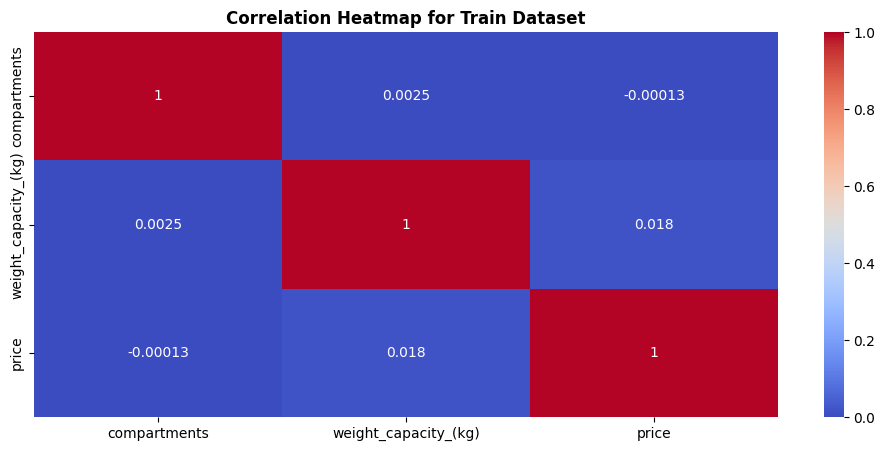

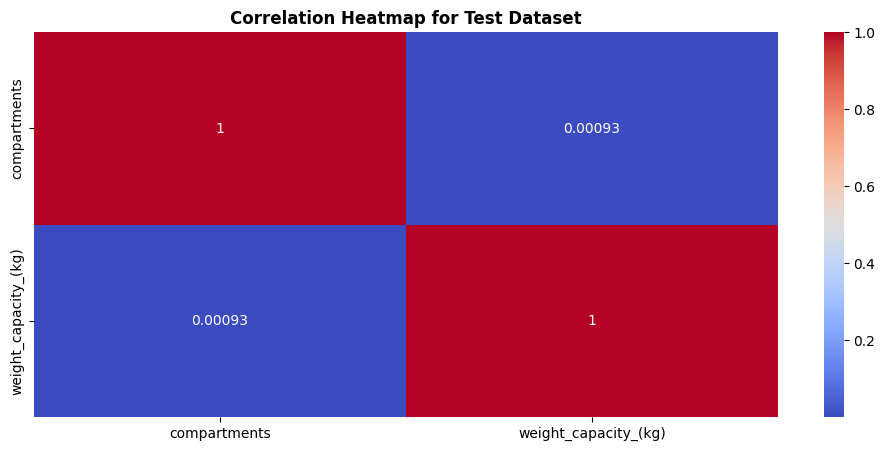

In [29]:
def heatmap(df, df_name):
    plt.figure(figsize=(12, 5))
    sns.heatmap(df.drop(columns=['id']).corr(method='pearson', numeric_only=True), 
                annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap for {df_name}', fontsize=12, weight='bold')
    plt.show()
    
heatmap(train_df, 'Train Dataset')   
heatmap(test_df, 'Test Dataset')

The heatmap above indicates that the continuous variables have a **very weak correlation** with the target variable **`price`**. The variable **`weight_capacity_(kg)`** shows a correlation of **0.018** with **price**, suggesting a **very weak positive correlation.**

# **Feature Engineering**

In [30]:
def create_interaction_features(df):
    for i, col1 in enumerate(categorical):
        for col2 in categorical[i+1:]:
            df[f"{col1}_x_{col2}"] = df[col1] + "_" + df[col2] 

# Binary variables - (yes/no) --> convert to 0 and 1
# For laptop_compartment and waterproof
def create_binary(df):
    df['laptop_compartment'] = df['laptop_compartment'].map({'Yes': 1, 'No':0})
    df['waterproof'] = df['waterproof'].map({'Yes': 1, 'No':0})
    # Create laptop_waterproof - backpack with laptop compartment and waterproof
    # Brands might price higher for waterproof backpacks with laptop compartment 
    df['laptop_waterproof'] = ((df['laptop_compartment'] == 'Yes') & (
        df['waterproof'] == 'Yes')).astype(int)
    
    return df

train_df = create_binary(train_df)
test_df = create_binary(test_df)   

In [31]:
train_df.head(1)   

,id,brand,material,size,compartments,laptop_compartment,waterproof,style,color,weight_capacity_(kg),price,laptop_waterproof
0,0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723,112.15875,0


In [32]:
# Changing the datatype for categorical variables from object to category in train_df 
for col in train_df.select_dtypes('object').columns:
    train_df[col] = train_df[col].astype('category')

# Changing the datatype for categorical variables from object to category in test_df 
for col in test_df.select_dtypes('object').columns:
    test_df[col] = test_df[col].astype('category')     

# **Model Construction** 

I created several aggregated features by grouping **`weight_capacity_(kg)`** with **`price`**, computing statistics such as **mean, median, count, and skew**. While these features improved my cross-validation scores, the test set performance slightly declined. To maintain generalization, I retained only the most effective feature - **`brand_weight_avg`**.

In [33]:
# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a new column initialized with NaNs
train_df['brand_material_avg'] = np.nan

# Perform KFold cross-validation
for train_idx, valid_idx in kf.split(train_df):
    train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[valid_idx]

    # Compute brand-material average price from training fold only
    brand_material_dict = train_fold.groupby(['brand', 'material'])['price'].mean().to_dict()

    # Assign to the validation fold
    train_df.loc[valid_idx, 'brand_material_avg'] = train_df.loc[valid_idx, ['brand', 'material']].apply(
        tuple, axis=1).map(brand_material_dict)

# Compute brand-material average price from the entire training set for the test set
brand_material_dict_full = train_df.groupby(['brand', 'material'])['price'].mean().to_dict()
test_df['brand_material_avg'] = test_df[['brand', 'material']].apply(tuple, axis=1).map(brand_material_dict_full)

# Verify if any missing values exist 
print("Missing values in train_df for `brand_material_avg:", train_df['brand_material_avg'].isna().sum())
print("Missing values in test_df for `brand_material_avg:", test_df['brand_material_avg'].isna().sum())       

Missing values in train_df for `brand_material_avg: 0
Missing values in test_df for `brand_material_avg: 0


In [34]:
# Set features and target
X_train = train_df.drop(columns=['id', 'price'])   
X_test = test_df.drop(columns=['id'])
y_train = train_df['price']  

In [35]:
# Function to compute RMSE  
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 

# Define the best hyperparameters 
best_params = {'n_estimators': 13000, 
               'learning_rate': 0.0068, 
               'num_leaves': 270, 
               'max_depth': 2, 
               'min_child_samples': 400, 
               'subsample': 0.8, 
               'colsample_bytree': 0.75, 
               'reg_alpha': 41.46, 
               'reg_lambda': 70, 
               'cat_smooth': 60, 
               'min_gain_to_split': 2.0, 
               'max_bin': 140}

# Train LightGBM model 
oof_predictions = np.zeros(len(train_df))   
light_gbm_test_preds = np.zeros(len(test_df))

# Store per-fold RMSE
fold_rmse_list = []  

# Train LightGBM with KFold
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):  
    print(f"\n### Training Model - Fold {fold+1} ###")

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = lgb.LGBMRegressor(**best_params, verbose=-1)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # OOF Predictions
    val_preds = model.predict(X_val)
    oof_predictions[valid_idx] = val_preds

    # Calculate RMSE for each fold
    fold_rmse = rmse(y_val, val_preds)

    print(f'Fold {fold+1} RMSE: {fold_rmse:.6f}')  

    # Test Set Predictions (Averaged over folds)
    light_gbm_test_preds += model.predict(X_test) / n_splits 

# Compute final CV RMSE
cv_score = rmse(y_train, oof_predictions)
print(f"\n Overall CV RMSE (LightGBM): {cv_score:.6f}")     


### Training Model - Fold 1 ###
Fold 1 RMSE: 38.912927

### Training Model - Fold 2 ###
Fold 2 RMSE: 39.042875

### Training Model - Fold 3 ###
Fold 3 RMSE: 39.019496

### Training Model - Fold 4 ###
Fold 4 RMSE: 39.075827

### Training Model - Fold 5 ###
Fold 5 RMSE: 39.008049

 Overall CV RMSE (LightGBM): 39.011873


# **Feature Importance**

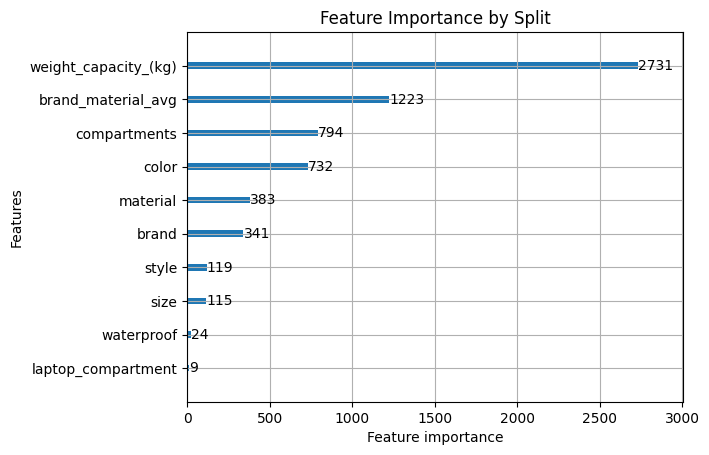

In [36]:
# Plot Feature Importance (Split)
lgb.plot_importance(model.booster_, importance_type='split')
plt.title('Feature Importance by Split');        

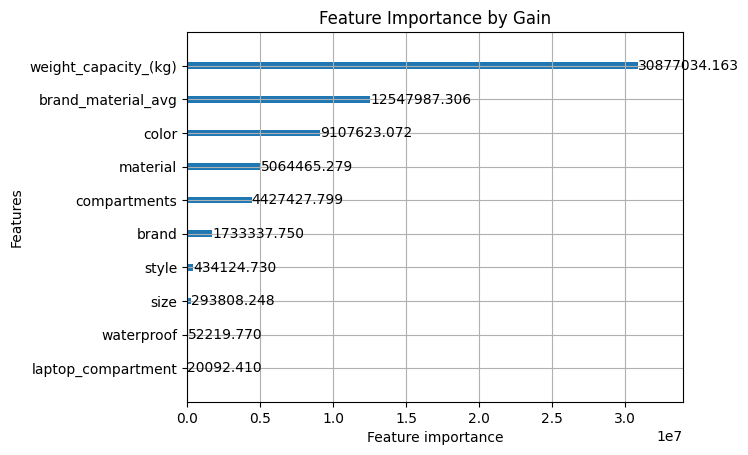

In [37]:
# Plot Feature Importance (Gain)
lgb.plot_importance(model.booster_, importance_type='gain')
plt.title('Feature Importance by Gain');  

**`Weight_capacity_(kg)`** is the most important and dominant feature in both **gain** and **split**, indicating its strong influence on price prediction and effectiveness in reducing **RMSE**. Categorical interactions—**`brand_material`**, **`brand_size`**, **`brand_waterproof`**, and **`style_size`** — are valuable as they rank highly in both gain and split importance, suggesting they provide meaningful differentiation. Among these, **`brand_material`** and **`brand_size`** show particularly high gain. Additionally, **`brand_material_avg`** (**categorical mean encoding**) proves especially useful in gain-based feature importance. 

In [38]:
# Ensure test predictions are non-negative
test_predictions = np.maximum(light_gbm_test_preds, 0)   

# Create the submission DataFrame      
submission = pd.DataFrame({
    'id': test_df['id'],
    'Price': test_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print('Final submission file created')                     

Final submission file created


In [39]:
submission.head()

,id,Price
0,300000,81.565607
1,300001,82.844480
2,300002,81.508510
3,300003,81.349309
4,300004,79.529812


In [40]:
submission['Price'].describe() 

count    200000.000000
mean         81.419846
std           1.489580
min          72.116060
25%          80.544478
50%          81.511546
75%          82.433767
max          85.388084
Name: Price, dtype: float64

In [41]:
submission['Price'].skew()            

-0.7378546493191246

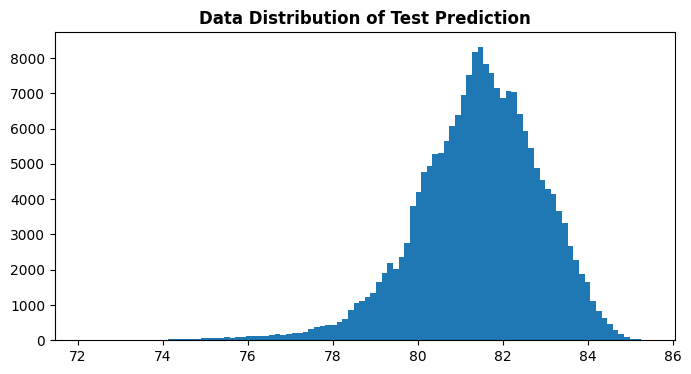

In [42]:
plt.figure(figsize=(8, 4))
plt.hist(data=submission, x='Price', bins=100)
plt.title('Data Distribution of Test Prediction', size=12, weight='bold');